In [1]:
from fastai.basics import *

In [2]:
import numpy as np

np.random.rand(5, 5)

array([[0.225513, 0.10557 , 0.145855, 0.596106, 0.560052],
       [0.433763, 0.133245, 0.593012, 0.604299, 0.795295],
       [0.382444, 0.480018, 0.528661, 0.277652, 0.385214],
       [0.720275, 0.46434 , 0.186377, 0.655814, 0.99722 ],
       [0.574814, 0.969047, 0.806011, 0.710947, 0.846836]])

In [3]:
np.random.seed(42)

In [4]:
a = torch.rand((784, 10))

In [5]:
b = torch.ones(10)

In [6]:
a + b

tensor([[1.5342, 1.2564, 1.6717,  ..., 1.5007, 1.3961, 1.7280],
        [1.4550, 1.2137, 1.5583,  ..., 1.3620, 1.4400, 1.6909],
        [1.9816, 1.9247, 1.1973,  ..., 1.6788, 1.0513, 1.5569],
        ...,
        [1.1765, 1.8314, 1.8742,  ..., 1.4151, 1.0608, 1.2688],
        [1.2371, 1.4823, 1.1392,  ..., 1.3516, 1.2628, 1.6898],
        [1.4940, 1.2348, 1.6740,  ..., 1.9008, 1.7778, 1.7814]])

In [35]:
class myLinear(nn.Module):
    def __init__(self, input, out, bias=True):
        super().__init__()
        self.bias = bias
        self.in_features = input
        self.out_features = out
        
        self.w = torch.nn.Parameter(torch.rand((input, out)))
        self.bias_vector = torch.nn.Parameter(torch.ones(self.out_features))
        
    def forward(self, x):
        if self.bias:
            return x.matmul(self.w) + self.bias_vector
        return x @ self.w
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias}'

In [36]:
my = myLinear(784, 10)

In [37]:
my

myLinear(in_features=784, out_features=10, bias=True)

In [38]:
a = torch.rand(1, 784)

In [39]:
my(a)

tensor([[205.0863, 202.3568, 202.4911, 197.1956, 195.0725, 197.4139, 190.3789,
         190.2675, 195.0119, 200.7887]], grad_fn=<AddBackward0>)

In [40]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = myLinear(784, 10)
        
    def forward(self, x):
        return self.linear(x)

In [41]:
model = Mnist_Logistic()

In [42]:
model.linear

myLinear(in_features=784, out_features=10, bias=True)

# MNIST SGD

In [43]:
import gzip, pickle
with gzip.open('mnist.pkl.gz', 'rb') as f:
    ((X_train, y_train), (X_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

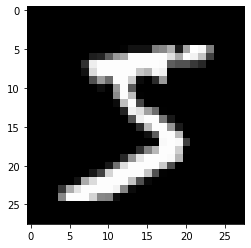

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
image = X_train[0].reshape(28, 28)
plt.imshow(image, cmap='gray')

In [18]:
# map the data into tensors
X_train, y_train, X_valid, y_valid = map(torch.tensor, (X_train, y_train, X_valid, y_valid))
n, c = X_train.shape
X_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [19]:
# split the data into batches
bs=64
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) # Creates torch.DataLoaders

In [20]:
X, y = next(iter(data.train_dl))
X.shape, y.shape

Traceback (most recent call last):
  File "/home/kelwa/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/kelwa/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/kelwa/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/kelwa/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


(torch.Size([64, 784]), torch.Size([64]))

In [44]:
model.to('cuda')

Mnist_Logistic(
  (linear): myLinear(in_features=784, out_features=10, bias=True)
)

In [45]:
model(X).shape

torch.Size([64, 10])

In [46]:
[p.shape for p in model.parameters()]

[torch.Size([784, 10]), torch.Size([10])]

In [47]:
lr=2e-2

In [48]:
loss_func = nn.CrossEntropyLoss()

In [68]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x) # make a prediction
    
    # Weight Decay
    w2 = 0.
    for p in model.parameters(): 
        w2 += (p**2).sum()
    
    # add to regular loss: L2 Regularization
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward() 
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr*p.grad)
            p.grad.zero_()
    return loss.item()

In [50]:
losses = [update(x,y,lr) for x, y in data.train_dl]

In [51]:
len(losses)

781

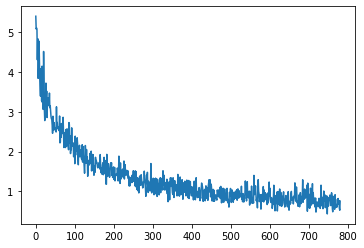

In [52]:
plt.plot(losses)

In [92]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = myLinear(784, 50, bias=True)
        self.lin2 = myLinear(50, 10, bias=True)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        return self.lin2(x)

In [93]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat,y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [94]:
model = Mnist_NN().cuda()

In [95]:
losses = [update(x,y,lr) for x,y in data.train_dl]

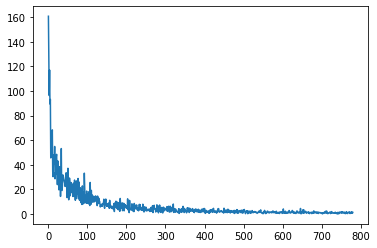

In [96]:
plt.plot(losses)

In [97]:
model = Mnist_NN().cuda()

In [58]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat,y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [98]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

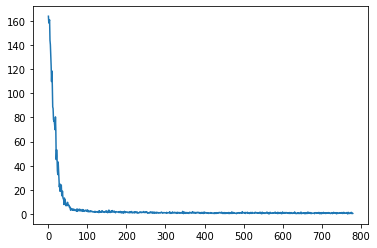

In [99]:
plt.plot(losses)

In [100]:
class Mnist_NN_IN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [101]:
def update(x,y,lr):
    opt = optim.Adam(model_in.parameters(), lr)
    y_hat = model_in(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [102]:
model_in = Mnist_NN_IN().cuda()
losses = [update(x,y,lr) for x, y in data.train_dl]

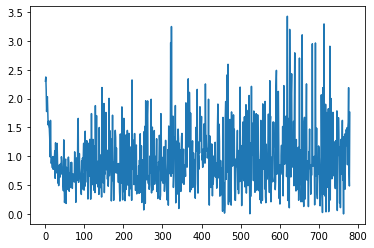

In [103]:
plt.plot(losses)

In [104]:
# change lr
model_in = Mnist_NN_IN().cuda()
losses = [update(x,y,1e-3) for x, y in data.train_dl]

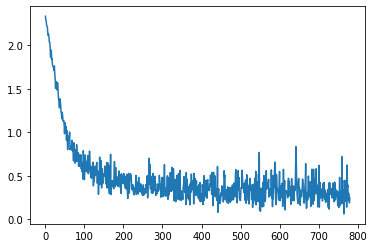

In [105]:
plt.plot(losses)